In [25]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import r_regression, SelectKBest

# Import the functions created for reusability from the Python file
from task3_1 import remove_outliers, remove_no_variance, standardise_features, pearson_correlation_matrix, \
    fill_missing_dates, fill_missing_quarters, fill_missing_days, convert_date_to_cols

## Star Dataset Pre-processing

#### Load the Star Dataset

In [26]:
star_file_name = 'datasets/star_assessment.csv'
star_features = np.genfromtxt(star_file_name, delimiter=',', skip_header=True, encoding="utf-8", usecols=range(0, 17))
star_labels = np.genfromtxt(star_file_name, delimiter=',', skip_header=True, encoding="utf-8", usecols=17, dtype=None)

In [27]:
# Explore the star dataset
print(f'Number of samples: {star_features.shape[0]}')
print(f'Number of features: {star_features.shape[1]-1}')
print(f'Number of classes: {np.unique(star_labels).shape[0]}')
print(f'Class names: {np.unique(star_labels)}')

Number of samples: 100000
Number of features: 16
Number of classes: 3
Class names: ['GALAXY' 'QSO' 'STAR']


Since there are only 3 classes, the star dataset is clearly a classification task

#### Filling in Missing Values

In [28]:
# Count the number of missing values in each column
missing_vals = np.sum(np.isnan(star_features), axis=0)
for k, v in enumerate(missing_vals):
    print(f'Column {k+1}: {v} missing values')
print(f'Total: {sum(missing_vals)} missing values')

Column 1: 60 missing values
Column 2: 55 missing values
Column 3: 65 missing values
Column 4: 70 missing values
Column 5: 63 missing values
Column 6: 50 missing values
Column 7: 59 missing values
Column 8: 61 missing values
Column 9: 59 missing values
Column 10: 51 missing values
Column 11: 68 missing values
Column 12: 59 missing values
Column 13: 58 missing values
Column 14: 49 missing values
Column 15: 50 missing values
Column 16: 61 missing values
Column 17: 62 missing values
Total: 1000 missing values


In [29]:
# Use a KNN imputer to fill in the missing values
knn_imputer = KNNImputer()
star_features_imputed = knn_imputer.fit_transform(star_features)

missing_vals = np.sum(np.isnan(star_features_imputed), axis=0)
print(f'Total: {sum(missing_vals)} missing values')

Total: 0 missing values


#### Encoding the Class Labels

In [30]:
# Encode the class labels
label_encoder = LabelEncoder()
star_labels_encoded = label_encoder.fit_transform(star_labels)

print(f'Encoded labels: {np.unique(star_labels_encoded)}')

Encoded labels: [0 1 2]


#### Removing Samples with Outliers

In [31]:
sample_size_with_outliers = star_features_imputed.shape[0]
star_features_without_outliers, star_labels_without_outliers = remove_outliers(star_features_imputed, star_labels_encoded)

print(f'Number of samples: {sample_size_with_outliers - star_features_without_outliers.shape[0]}')

Number of samples: 14387


#### Remove Features with No Variance

In [32]:
# Use a variance threshold to remove any features with zero variance
star_features_no_variance_removed, removed_columns = remove_no_variance(star_features_without_outliers)

print(f"Removed column indexes: {removed_columns}")

Removed column indexes: [9]


In this case, the `rerun_ID` feature has zero variance, so it is removed.


#### Feature Scaling

Scale the features to have a mean of 0 and a standard deviation of 1 before feature selection to avoid biasing the feature selection process with high-scale features.

In [33]:
# Scale the features
star_features_standardised = standardise_features(star_features_no_variance_removed)

#### Feature Selection Using the Filter Method

In [34]:
# Then use the f_classif method to determine the correlation between each feature and the class labels
select_k_best = SelectKBest(k='all')
select_k_best.fit(star_features_standardised, star_labels_without_outliers)

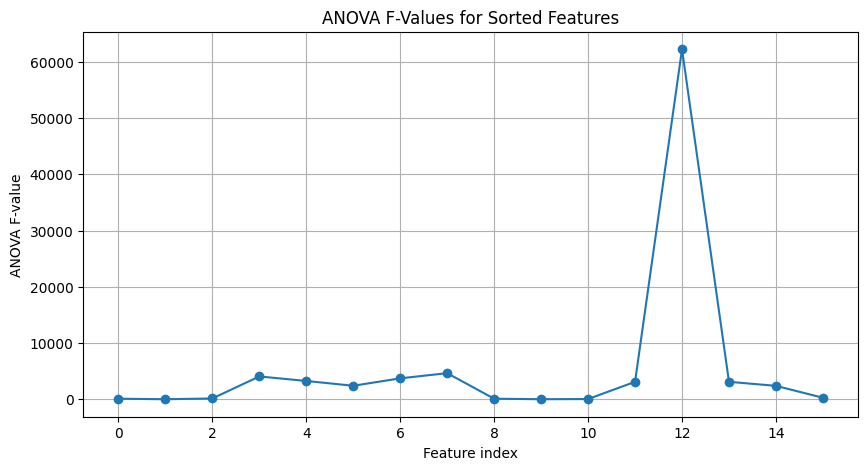

In [35]:
# Plot the sorted ANOVA F-values
plt.figure(figsize=(10, 5))
plt.plot(select_k_best.scores_, marker='o')
plt.xlabel('Feature index')
plt.ylabel('ANOVA F-value')
plt.title('ANOVA F-Values for Sorted Features')
plt.grid(True)

# Display the plot
plt.show()

Based on the plot above, we can see that the features with indexes  3 (`u`), 4 (`g`), 5 (`r`), 6 (`i`), 7 (`z`), 11 (`spec_obj_ID`), 12 (`redshift`), 13 (`plate`), and 14 (`MJD`) have significantly higher ANOVA F-values than the other features, thus they have a stronger influence on the target. Additionally, the upon further investigation into what each column represents through visiting [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17), seemingly these features are the most relevant to the classification of an object as a star, galaxy, or quasar.

Therefore, the features that will be dropped are:
- `obj_ID`: given that it is just an identifier, it does not provide any useful information for classification and would only add noise to the model.
- `alpha`: this feature represents the right ascension of the object, which is a coordinate used to locate objects in the sky. It shouldn't provide any benefit to the model in the classification of an object as a star, galaxy, or quasar as they are distributed across the sky.
- `delta`: similar to `alpha`, this column represents the declination of the object, which is also a coordinate for locating objects thus it shouldn't provide any benefit to the model.
- `run_ID`: this feature refers to a specific scan of the sky, which is an identifier for the run that the object was observed in. It shouldn't provide any benefit to the model as it isn't related to the detection of an object as a star, galaxy, or quasar.
- `cam_col`: this feature represents the camera column used during the observation. Like the `run_ID`, it is not related to the object's properties thus is less relevant to the classification task.
- `field_ID`: this feature represents the field number of the observation. It is also not related to the object's properties so shouldn't be relevant to the classification task.
- `fiber_ID`: this refers to the fiber number used to capture the spectrum of the object. The feature is not related to the object's properties so won't provide any benefit to the model.

In [36]:
# Drop the features as described above
star_features_selected = np.delete(star_features_standardised, [0, 1, 2, 8, 9, 10, 15], axis=1)

# Print the number of features
print(f'Number of features: {star_features_selected.shape[1]}')

Number of features: 9


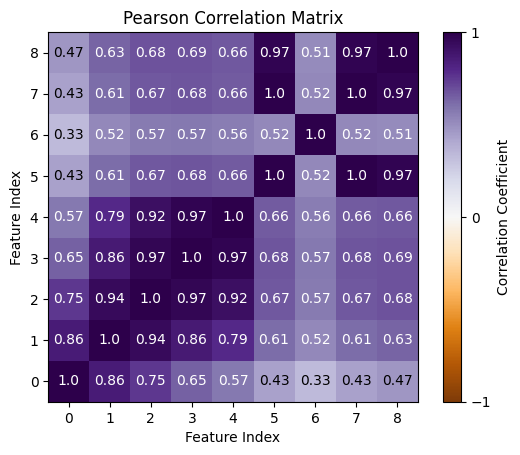

In [37]:
pearson_correlation_matrix(star_features_selected)

From this matrix, it is clear that the following features are highly correlated:
- 0 (`u`), 1 (`g`), 2 (`r`), 3 (`i`) and 4 (`z`) have a chain of correlations
- 5 (`spec_obj_ID`), 7 (`plate`) and 8 (`MJD`) have linear correlations

It makes sense that several of the features related to the photometric system are correlated as they represent the intensity of the object's light at different wavelengths. Since objects emit light across a range of wavelengths, it is expected that the light will be correlated across the different filters.

## GWP Dataset Pre-processing

#### Load the GWP dataset

In [38]:
gwp_file_name = 'datasets/gwp_assessment.csv'
gwp_categorical = np.genfromtxt(gwp_file_name, delimiter=',', skip_header=True, encoding="utf-8", dtype=str, usecols=range(0, 4))
gwp_numerical = np.genfromtxt(gwp_file_name, delimiter=',', skip_header=True, encoding="utf-8", dtype=np.float64, usecols=range(4, 14))
gwp_values = np.genfromtxt(gwp_file_name, delimiter=',', skip_header=True, encoding="utf-8", dtype=np.float64, usecols=14)

In [39]:
# Explore the gwp dataset
print(f'Number of samples: {gwp_categorical.shape[0]}')
print(f'Number of features: {gwp_categorical.shape[1] + gwp_numerical.shape[1]}')
print(f'Number of classes: {np.unique(gwp_values).shape[0]}')

Number of samples: 1197
Number of features: 14
Number of classes: 879


Since there are 879 classes, this is clearly a regression task. Additionally, unlike the star dataset, since there are categorical features in this dataset, these will need to be explored and encoded appropriately

#### Explore Categorical Features

First let's look at `quarter`, `date` and `day`

In [40]:
unique_quarter_values, counts = np.unique(gwp_categorical[:, 1], return_counts=True)

# Print unique values along with their counts
for value, count in zip(unique_quarter_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: , Count: 11
Value: Quarter1, Count: 357
Value: Quarter2, Count: 332
Value: Quarter3, Count: 207
Value: Quarter4, Count: 246
Value: Quarter5, Count: 44


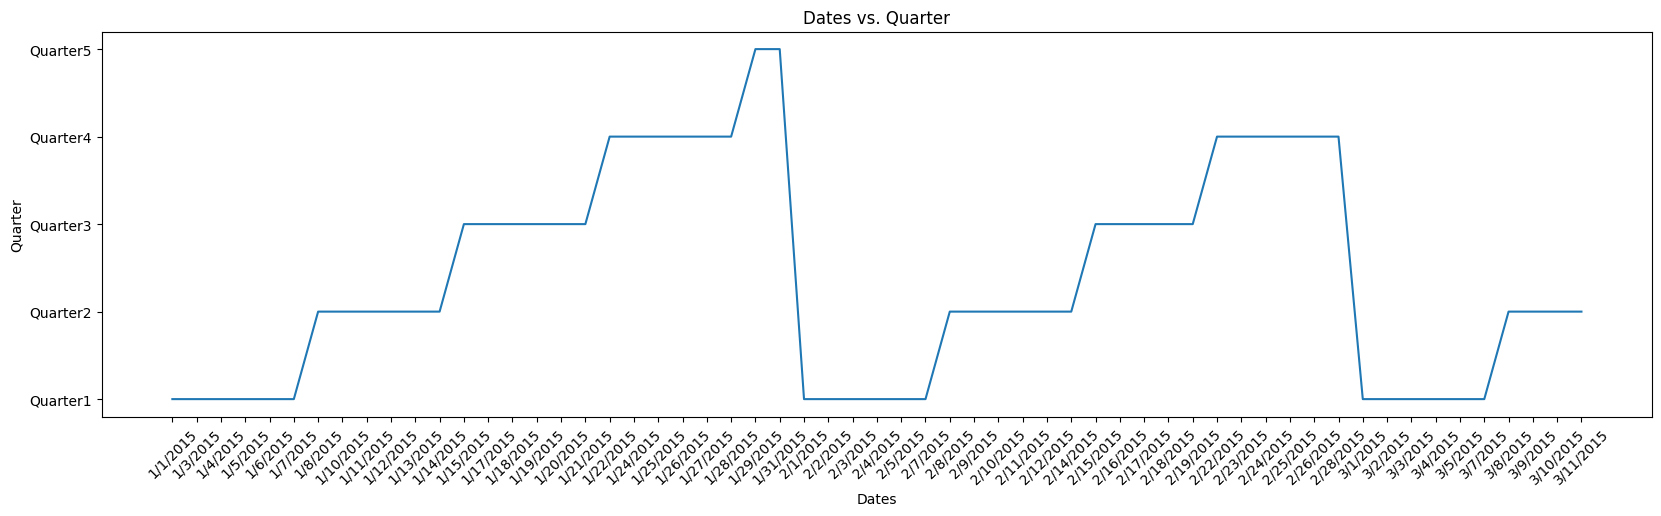

In [41]:
# Plot the dates against each quarter
plt.figure(figsize=(20, 5))
gwp_categorical_no_nulls = gwp_categorical[~(gwp_categorical == '').any(axis=1)]
plt.plot(gwp_categorical_no_nulls[:, 0], gwp_categorical_no_nulls[:, 1])
plt.xlabel('Dates')
plt.ylabel('Quarter')
plt.title('Dates vs. Quarter')
plt.xticks(rotation=45)

plt.show()

From the plot above, it is clear that quarters 1, 2, 3 and 4 usually follow a consistent pattern in their length (one week) and when they occur (start every Thursday). The main point of deviation from this pattern is quarter 5, which happens once and appears to last for only two days.

In [42]:
# Let's determine whether any samples are missing more than one of the date, day and quarter features
missing_samples = np.column_stack((gwp_categorical[:, 0] == '', gwp_categorical[:, 1] == '', gwp_categorical[:, 3] == ''))
missing_count = np.sum(missing_samples, axis=1)
rows_with_multiple_missing = np.where(missing_count > 1)[0]

print(f"Number of rows with more than one missing value: {rows_with_multiple_missing.shape[0]}")

Number of rows with more than one missing value: 0


Since no rows are missing more than one of the date, day and quarter features, the missing value can be inferred from the remaining features.

In [43]:
gwp_categorical_filled = fill_missing_dates(gwp_categorical)
gwp_categorical_filled = fill_missing_quarters(gwp_categorical_filled)
gwp_categorical_filled = fill_missing_days(gwp_categorical_filled)

# Print the number of missing values in these features
print(f"Number of missing values in date column: {np.sum(gwp_categorical_filled[:, 0] == '')}")
print(f"Number of missing values in quarter column: {np.sum(gwp_categorical_filled[:, 1] == '')}")
print(f"Number of missing values in day column: {np.sum(gwp_categorical_filled[:, 3] == '')}")

Number of missing values in date column: 0
Number of missing values in quarter column: 0
Number of missing values in day column: 0


In [44]:
# Next let's look at the `department` categorical feature
unique_values, counts = np.unique(gwp_categorical_filled[:, 2], return_counts=True)

# Print unique values along with their counts
for value, count in zip(unique_values, counts):
    print(f'Value: {value}, Count: {count}')

Value: , Count: 7
Value: finishing, Count: 246
Value: finishing , Count: 257
Value: sweing, Count: 687


There appears to be two departments, `sweing` and `finishing`. However, some `finishing` values have been entered with a trailing space, which will need to be removed.

In [45]:
# Remove the trailing space from the `finishing` values
gwp_categorical_filled[:, 2] = np.char.strip(gwp_categorical_filled[:, 2])

Given that there are only seven samples missing the `department` feature let's drop those samples

In [46]:
# Drop the samples missing the `department` feature
mask = gwp_categorical_filled[:, 2] != ''
gwp_categorical_filled = gwp_categorical_filled[mask]
gwp_numerical = gwp_numerical[mask]
gwp_values = gwp_values[mask]

#### Encode Categorical Features

First let's convert the `date` feature into several numerical features: `year`, `month` and `day`

In [47]:
gwp_categorical_date_encoded = convert_date_to_cols(gwp_categorical_filled, 0)

We can use one-hot encoding to encode the `quarter`, `department` and `day` features

In [48]:
# Create a copy of the first three columns of gwp_categorical_date_encoded
gwp_categorical_ohc = gwp_categorical_date_encoded[:, :3].copy()

for i in range(3, 6):
    ohc = OneHotEncoder(categories='auto', dtype=float, sparse_output=False)
    new_col = ohc.fit_transform(gwp_categorical_date_encoded[:, [i]])
    gwp_categorical_ohc = np.hstack((gwp_categorical_ohc, new_col))

#### Numerical Values

In [49]:
# Count the number of missing values in each column
missing_numerical_vals = np.sum(np.isnan(gwp_numerical), axis=0)
for k, v in enumerate(missing_numerical_vals):
    print(f'Column {k+1}: {v} missing values')
print(f'Total: {sum(missing_numerical_vals)} missing values')

Column 1: 12 missing values
Column 2: 16 missing values
Column 3: 8 missing values
Column 4: 503 missing values
Column 5: 9 missing values
Column 6: 5 missing values
Column 7: 12 missing values
Column 8: 11 missing values
Column 9: 12 missing values
Column 10: 10 missing values
Total: 598 missing values


From this it is clear that the `wip` feature has many missing values. Therefore, this feature needs to be investigated further.

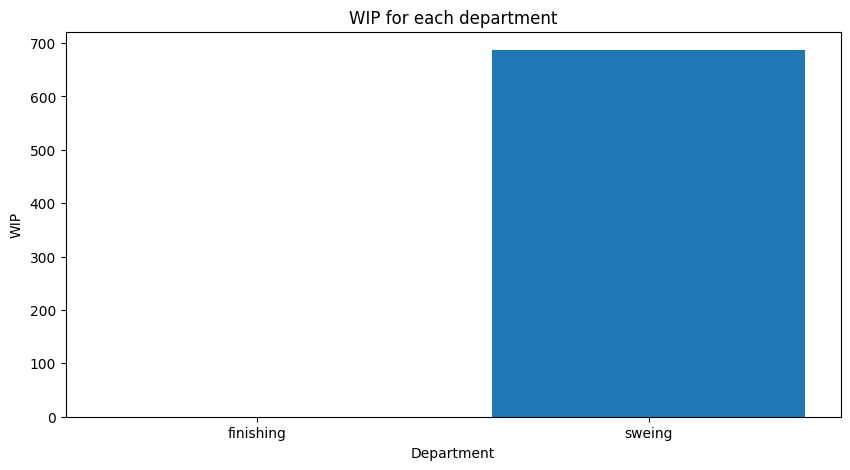

In [50]:
# Plot a bar chart of the `wip` feature for each department
department = np.unique(gwp_categorical_filled[:, 2])
# Count the number of non-null values in the `wip` feature for each department
wip = np.zeros(department.shape[0])
for i, dept in enumerate(department):
    wip[i] = np.sum(~np.isnan(gwp_numerical[gwp_categorical_filled[:, 2] == dept, 3]))

plt.figure(figsize=(10, 5))
plt.bar(department, wip)
plt.xlabel('Department')
plt.ylabel('WIP')
plt.title('WIP for each department')
plt.show()

From the plot above, it is clear that the `wip` feature is missing for all samples in the `finishing` department. Based on the definition of the `wip` feature (work in progress, includes the number of unfinished items for products), it appears to be not applicable to the `finishing` department. Therefore, we can just fill in the missing values with zeros where the department is `finishing`.

In [51]:
# Fill in the missing values in the `wip` feature with zeros when the department is `finishing`
gwp_numerical[(gwp_categorical_filled[:, 2] == 'finishing') & (np.isnan(gwp_numerical[:, 3])), 3] = 0

For the remaining missing values, we can use a KNN imputer to fill in the missing values. However, first let's combine the categorical and numerical features into a single numpy array.

In [52]:
gwp_features = np.hstack((gwp_categorical_ohc, gwp_numerical))

knn_imputer = KNNImputer()
gwp_features_imputed = knn_imputer.fit_transform(gwp_features)

missing_vals = np.sum(np.isnan(gwp_features_imputed), axis=0)
print(f'Total: {sum(missing_vals)} missing values')

Total: 0 missing values


Next, let's one-hot encode the `team` feature as it can be considered a categorical feature. Before this, we need to round the values in the `team` feature to the nearest integer as they may have been imputed with decimal values.

In [53]:
# Round the values in the `team` feature to the nearest integer
gwp_features_imputed[:, 16] = np.round(gwp_features_imputed[:, 16])

In [54]:
# One-hot encode the `team` feature then replace the original `team` feature with the encoded features
ohc = OneHotEncoder(categories='auto', dtype=float, sparse_output=False)
team = ohc.fit_transform(gwp_features_imputed[:, [16]])
gwp_features_encoded = np.hstack((gwp_features_imputed[:, :16], team, gwp_features_imputed[:, 17:]))

#### Remove Features with No Variance

In [55]:
gwp_features_no_variance_removed, removed_columns = remove_no_variance(gwp_features_encoded)

print(f"Removed column indexes: {removed_columns}")

Removed column indexes: [0]


#### Standardise Features and Target Variable

In [56]:
gwp_features_standardised = standardise_features(gwp_features_no_variance_removed, cols=range(27, 36))
scaler = StandardScaler()
gwp_values_standardised = scaler.fit_transform(gwp_values.reshape(-1, 1)).flatten()

#### Feature Selection

For performing feature selection on this dataset, we will use the Pearson correlation coefficient as the target variable is continuous. A threshold of 0.1 will be used as a guideline to select the features, along with knowledge gained through looking at the definition of each feature.

In [57]:
select_k_best = SelectKBest(r_regression)
select_k_best.fit(gwp_features_standardised, gwp_values_standardised)

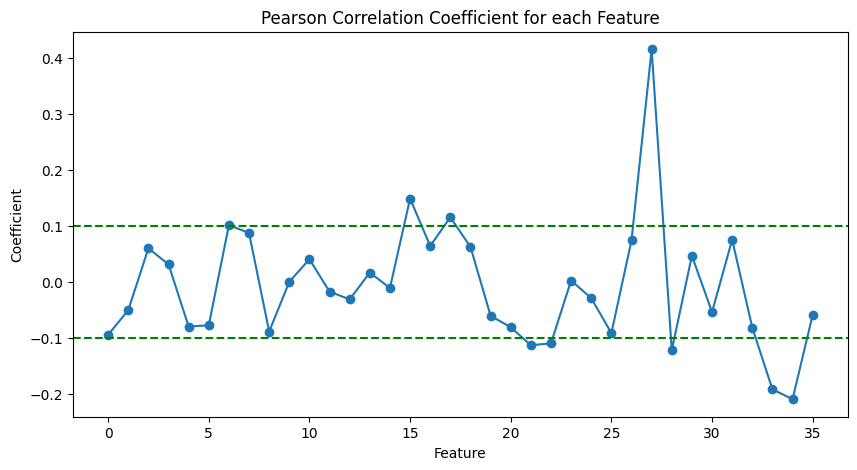

In [58]:
# plot the scores on a line graph
plt.figure(figsize=(10, 5))
plt.plot(select_k_best.scores_, marker='o')
plt.axhline(y=0.1, color='g', linestyle='--')
plt.axhline(y=-0.1, color='g', linestyle='--')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Pearson Correlation Coefficient for each Feature')
plt.show()

Based on the plot above, we can select the following features:
- `team` (one-hot encoded): despite all the one-hot encoded `team` features not having a correlation coefficient greater than 0.1, we will keep all of them as they are all related to the same feature.
- `targeted_productivity`: this feature has the highest correlation coefficient.
- `smv`: this feature has a correlation coefficient less than -0.1, and it makes sense that the standard minute value of a task would affect the productivity.
- `idle_men`: this feature also has a correlation coefficient less than -0.1, and relates to the number of workers that were idle due to production interruption.
- `no_of_style_change`: this feature has a correlation coefficient less than -0.1, and represents the number of times the style of a product was changed during production.

In [59]:
# Drop the remaining features
gwp_features_selected = np.delete(gwp_features_standardised, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                               11, 12, 13, 14, 29, 30, 31, 32, 33], axis=1)

# Print the number of features
print(f'Number of features: {gwp_features_selected.shape[1]}')

Number of features: 16


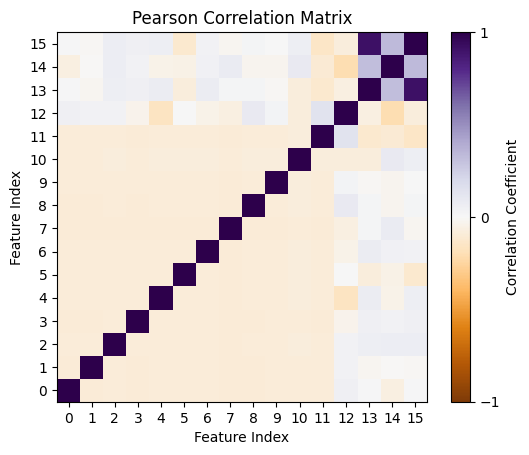

In [60]:
pearson_correlation_matrix(gwp_features_selected, show_coef=False)

The matrix shows that most of the selected features are not strongly correlated with each other, except for `smv` and `no_of_style_change`. However, since generally the features are not strongly correlated, we will keep all of them.

## Markdown Question

Markdown Question: Explain the logic behind usage of Pearson correlation coefficient for feature selection.

Using the Pearson correlation coefficient for feature selection is suitable when the target variable is continuous because it is a measure of the linear relationship between two variables. It can be used to measure the strength and correlation between each feature and the target variable to determine which have the greatest impact. The result for each feature is a value between -1 and 1, where -1 indicates a strong negative correlation, 0 indicates no correlation, and 1 indicates a strong positive correlation. Therefore, it is relatively simple to interpret the relationship between features and the target. It is common to set a threshold for coefficient values based on domain knowledge to determine which features to select. The Pearson correlation coefficient can also be used to identify features that have a high level of correlation with each other, with the aim of reducing multicollinearity.

In the context of feature selection in the two datasets pre-processed in this notebook, it was used to identify which features are most relevant to the target variable for the GWP dataset as the target was continuous. In contrast, it was not used for the STAR dataset as the target was categorical, but instead for examining the relationship between continuous features.